# Segmentation

### C++ opencv

returncode = 0
stdout:
 [ INFO:0@0.205] global registry_parallel.impl.hpp:96 cv::parallel::ParallelBackendRegistry::ParallelBackendRegistry core(parallel): Enabled backends(3, sorted by priority): ONETBB(1000); TBB(990); OPENMP(980)
[ INFO:0@0.206] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load C:\opencv\build\x64\vc16\bin\opencv_core_parallel_onetbb4120_64d.dll => FAILED
[ INFO:0@0.208] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load opencv_core_parallel_onetbb4120_64d.dll => FAILED
[ INFO:0@0.209] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load C:\opencv\build\x64\vc16\bin\opencv_core_parallel_tbb4120_64d.dll => FAILED
[ INFO:0@0.211] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load opencv_core_parallel_tbb4120_64d.dll => FAILED
[ INFO:0@0.211] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load C:\opencv\build\x64\vc16\bin\opencv

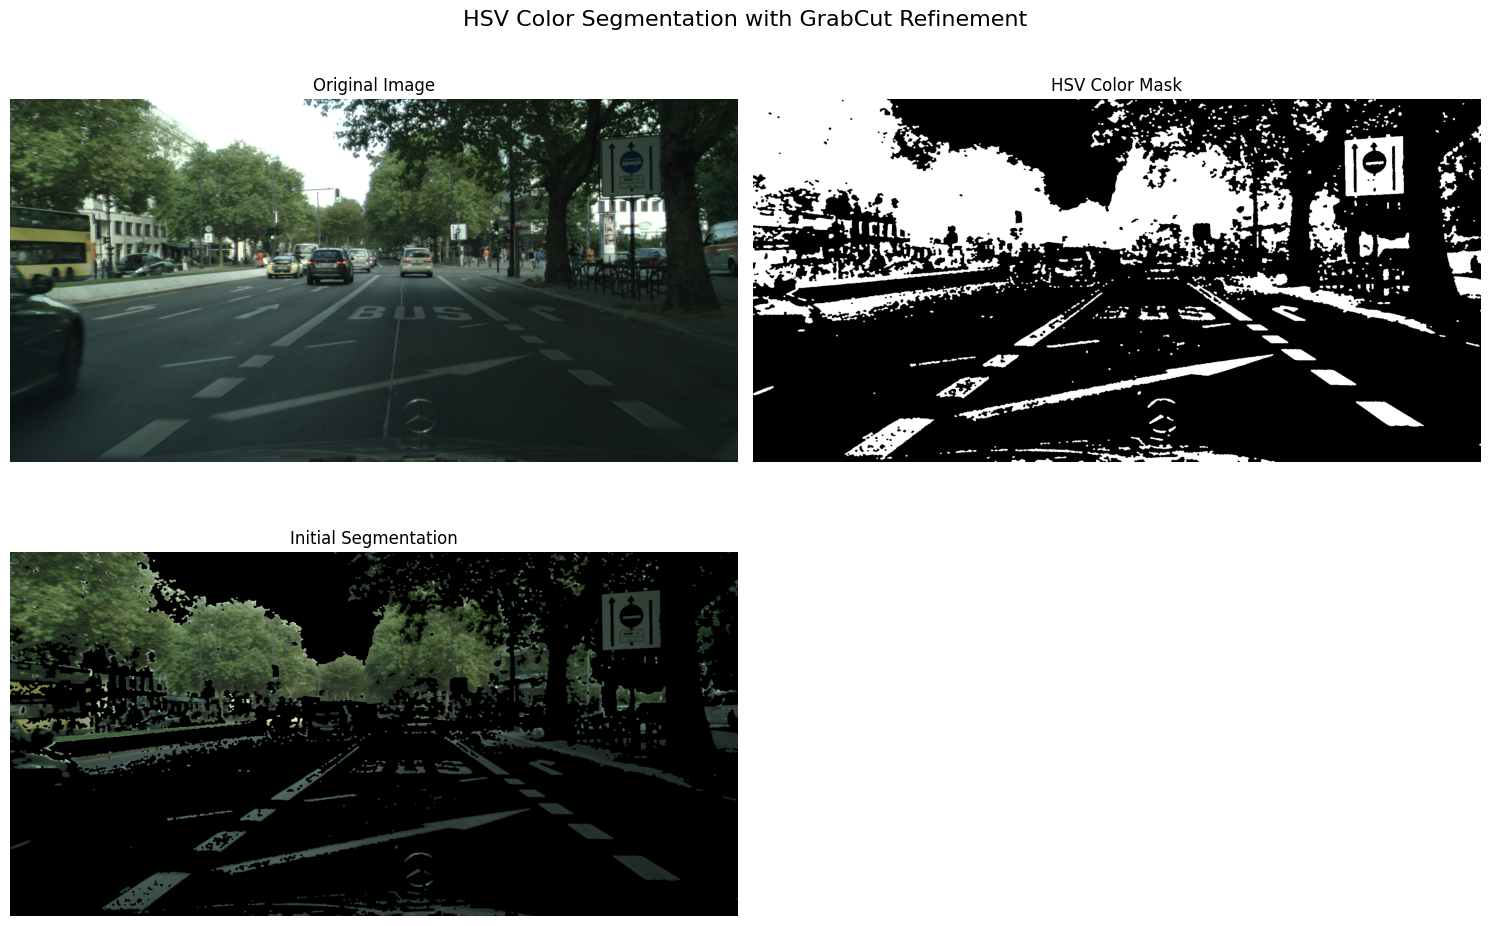

In [8]:
import subprocess, sys, shutil, os
exe_path = os.path.join('..', 'build', 'Debug', 'segmentation.exe')
if os.path.exists(exe_path):
    # Run the segmentation executable with --no-gui flag to avoid GUI dependencies
    proc = subprocess.run([exe_path, '../dataset/leftImg8bit_trainvaltest/test/berlin/berlin_000000_000019_leftImg8bit.png', '--no-gui'], 
                         capture_output=True, text=True)
    print('returncode =', proc.returncode)
    print('stdout:\n', proc.stdout)
    print('stderr:\n', proc.stderr)
    
    if proc.returncode == 0:
        from PIL import Image
        import matplotlib.pyplot as plt
        
        out_dir = 'out_images\seg'
        segmentation_imgs = [
            'segmentation_original.png',
            'segmentation_mask.png', 
            'segmentation_result.png',
            'grabcut_result.png'
        ]
        
        titles = [
            'Original Image',
            'HSV Color Mask', 
            'Initial Segmentation',
            'GrabCut Refined'
        ]
        
        plt.figure(figsize=(15,10))
        for i, (name, title) in enumerate(zip(segmentation_imgs, titles), 1):
            path = os.path.join(out_dir, name)
            if os.path.exists(path):
                im = Image.open(path).convert('RGB')
                plt.subplot(2,2,i)
                plt.imshow(im)
                plt.title(title)
                plt.axis('off')
            else:
                print(f"Image not found: {path}")
        
        plt.suptitle('HSV Color Segmentation with GrabCut Refinement', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # # Also show the transform results if they exist
        # transform_imgs = ['original.png','grayscale.png','gaussian_blur.png','canny_edges.png','resized.png','rotated.png','perspective.png','hsv.png','flipped.png']
        # existing_transforms = [img for img in transform_imgs if os.path.exists(os.path.join(out_dir, img))]
        
        # if existing_transforms:
        #     plt.figure(figsize=(12,8))
        #     for i, name in enumerate(existing_transforms, 1):
        #         path = os.path.join(out_dir, name)
        #         im = Image.open(path).convert('RGB')
        #         plt.subplot(3,3,i)
        #         plt.imshow(im)
        #         plt.title(name.replace('.png', '').replace('_', ' ').title())
        #         plt.axis('off')
        #     plt.suptitle('Image Transformations', fontsize=16)
        #     plt.tight_layout()
        #     plt.show()
    else:
        print(f"Segmentation failed with return code {proc.returncode}")
else:
    print('Executable not found at', exe_path)
    print('Please build the project first using: cmake --build build --config Debug')

### Python opencv

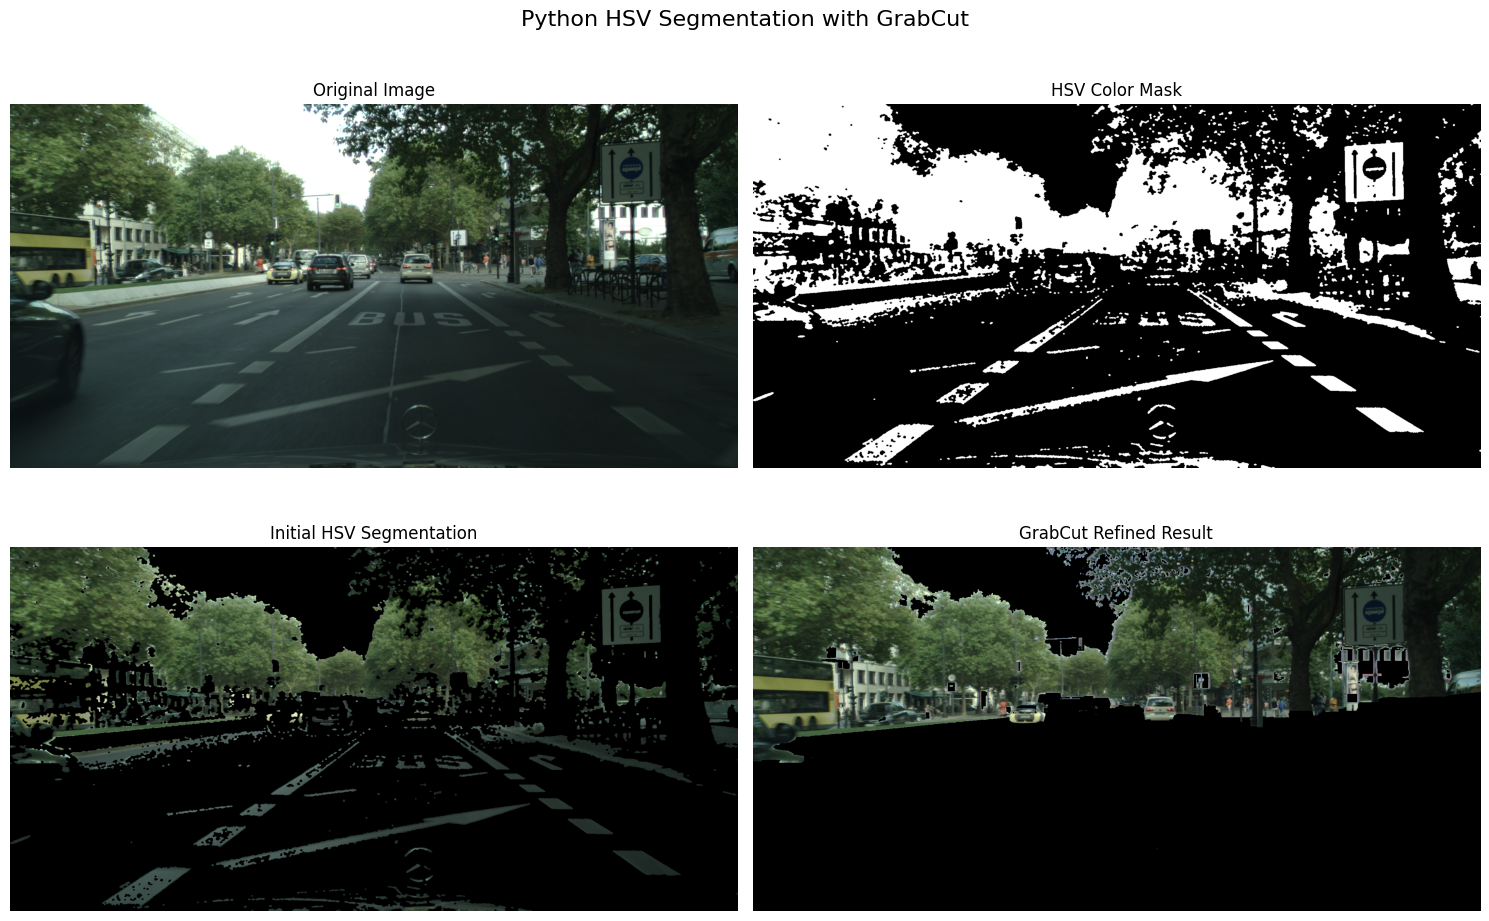

Python segmentation complete!


In [ ]:
# Python implementation of HSV segmentation with GrabCut
import cv2
import numpy as np
import matplotlib.pyplot as plt

def hsv_segmentation_with_grabcut(img_path):
    """
    Perform HSV color segmentation followed by GrabCut refinement
    """
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not load image {img_path}")
        return
    
    # Convert to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define HSV range for green-ish objects (same as C++ code)
    lower = np.array([35, 40, 40])
    upper = np.array([85, 255, 255])
    
    # Create initial mask
    mask = cv2.inRange(hsv, lower, upper)
    
    # Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Apply initial mask
    initial_result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
    
    # Prepare GrabCut
    grabcut_mask = np.zeros(mask.shape, np.uint8)
    grabcut_mask[mask == 255] = cv2.GC_PR_FGD  # Probable foreground
    grabcut_mask[mask == 0] = cv2.GC_PR_BGD    # Probable background
    
    # Initialize models
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    
    # Define rectangle (slightly smaller than image)
    rect = (1, 1, img.shape[1]-2, img.shape[0]-2)
    
    # Apply GrabCut
    cv2.grabCut(img, grabcut_mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)
    
    # Create final mask
    final_mask = np.where((grabcut_mask == cv2.GC_FGD) | (grabcut_mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
    
    # Apply Final mask
    grabcut_result = cv2.bitwise_and(img_rgb, img_rgb, mask=final_mask)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('HSV Color Mask')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(initial_result)
    axes[1, 0].set_title('Initial HSV Segmentation')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(grabcut_result)
    axes[1, 1].set_title('GrabCut Refined Result')
    axes[1, 1].axis('off')
    
    plt.suptitle('Python HSV Segmentation with GrabCut', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return img_rgb, mask, initial_result, grabcut_result

if __name__ == "__main__":
    img_path = '../dataset/leftImg8bit_trainvaltest/test/berlin/berlin_000000_000019_leftImg8bit.png'
    if os.path.exists(img_path):
        results = hsv_segmentation_with_grabcut(img_path)
        print("Python segmentation complete!")
    else:
        print(f"Image not found: {img_path}")
        print("Please make sure the dataset is available.")

### DNN-based Segmentation (C++)

In [10]:
"""
┌─────────────────┐    ┌──────────────────┐    ┌─────────────────┐
│   C++ Program   │───▶│  Python Wrapper  │───▶│   File System   │
│                 │    │                  │    │                 │
│ • Parse args    │    │ • Load SAM model │    │ • sam_original  │
│ • Build command │    │ • Run inference  │    │ • sam_masks     │
│ • Execute       │    │ • Save results   │    │ • sam_overlay   │
└─────────────────┘    └──────────────────┘    └─────────────────┘
         ▲                                               │
         │              ┌─────────────────┐              │
         └──────────────│   C++ Display   │◀─────────────┘
                        │                 │
                        │ • Load images   │
                        │ • Show windows  │
                        │ • Handle input  │
                        └─────────────────┘
"""

'\n┌─────────────────┐    ┌──────────────────┐    ┌─────────────────┐\n│   C++ Program   │───▶│  Python Wrapper  │───▶│   File System   │\n│                 │    │                  │    │                 │\n│ • Parse args    │    │ • Load SAM model │    │ • sam_original  │\n│ • Build command │    │ • Run inference  │    │ • sam_masks     │\n│ • Execute       │    │ • Save results   │    │ • sam_overlay   │\n└─────────────────┘    └──────────────────┘    └─────────────────┘\n         ▲                                               │\n         │              ┌─────────────────┐              │\n         └──────────────│   C++ Display   │◀─────────────┘\n                        │                 │\n                        │ • Load images   │\n                        │ • Show windows  │\n                        │ • Handle input  │\n                        └─────────────────┘\n'

Wrapper: python tools\sam_wrapper.py "dataset\leftImg8bit_trainvaltest\test\berlin\berlin_000000_000019_leftImg8bit.png" --mode auto --max-size 800

.\build\Debug\dnn_segmentation.exe "dataset\leftImg8bit_trainvaltest\test\berlin\berlin_000000_000019_leftImg8bit.png" --use-sam

returncode = 0
stdout:
 Loading MobileViT classification model for feature-based segmentation...
MobileViT model not found at: models/mobilevit/model.onnx
Trying alternative segmentation models...
No pre-trained DNN model found. Using advanced traditional segmentation methods...
[ INFO:0@0.214] global registry_parallel.impl.hpp:96 cv::parallel::ParallelBackendRegistry::ParallelBackendRegistry core(parallel): Enabled backends(3, sorted by priority): ONETBB(1000); TBB(990); OPENMP(980)
[ INFO:0@0.214] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load C:\opencv\build\x64\vc16\bin\opencv_core_parallel_onetbb4120_64d.dll => FAILED
[ INFO:0@0.217] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load opencv_core_parallel_onetbb4120_64d.dll => FAILED
[ INFO:0@0.217] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load C:\opencv\build\x64\vc16\bin\opencv_core_parallel_tbb4120_64d.dll => FAILED
[ INFO:0@0.221] gl

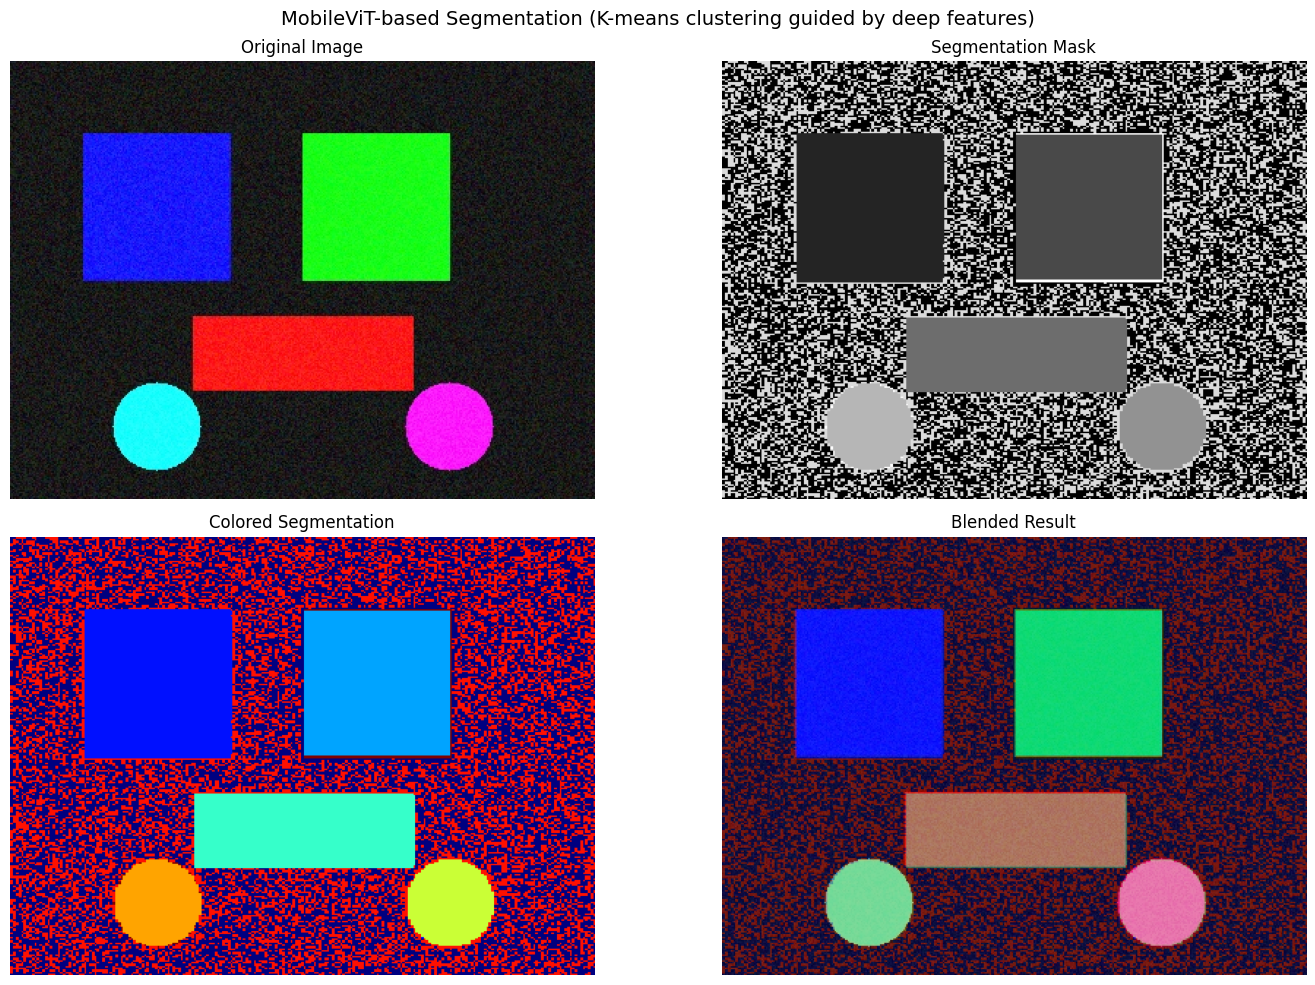


🎉 Successfully using MobileViT model for feature-based segmentation!
Features extracted: 1001-dimensional vector from classification model
Method: K-means clustering (K=8) on image pixels
Model: models/mobilevit/model.onnx


In [ ]:
import subprocess, sys, shutil, os
dnn_exe_path = os.path.join('..', 'build', 'Debug', 'dnn_segmentation.exe')

if os.path.exists(dnn_exe_path):
    proc = subprocess.run([dnn_exe_path, '../dataset/leftImg8bit_trainvaltest/test/berlin/berlin_000000_000019_leftImg8bit.png', '--no-gui'], 
                         capture_output=True, text=True)
    print('returncode =', proc.returncode)
    print('stdout:\n', proc.stdout)
    if proc.stderr:
        print('stderr:\n', proc.stderr)
    
    if proc.returncode == 0:
        from PIL import Image
        import matplotlib.pyplot as plt
        
        stdout_text = proc.stdout.lower()
        used_mobilevit = False
        used_traditional = False
        
        if "successfully loaded mobilevit model" in stdout_text:
            used_mobilevit = True
            print("STATUS: MobileViT model successfully loaded and used.")
        elif "mobilevit model not found" in stdout_text or "traditional segmentation" in stdout_text:
            used_traditional = True
            print("STATUS: MobileViT model not found - using traditional segmentation methods.")
        
        mobilevit_dir = os.path.join('out_images', 'mobilevit_seg')
        traditional_dir = os.path.join('out_images', 'traditional_seg')
        
        if used_mobilevit and os.path.exists(mobilevit_dir) and os.listdir(mobilevit_dir):
            out_dir = mobilevit_dir
            dnn_imgs = [
                'original.png',
                'segmentation_mask.png',
                'colored_segmentation.png',
                'blended_result.png'
            ]
            
            titles = [
                'Original Image',
                'Segmentation Mask',
                'Colored Segmentation', 
                'Blended Result'
            ]
            
            suptitle = 'MobileViT-based Segmentation (K-means clustering guided by deep features)'
            method_info = "mobilevit"
            
        elif used_traditional and os.path.exists(traditional_dir) and os.listdir(traditional_dir):
            out_dir = traditional_dir
            dnn_imgs = [
                'original.png',
                'binary.png',
                'distance_transform.png',
                'watershed_segmented.png'
            ]
            
            titles = [
                'Original Image',
                'Binary Mask',
                'Distance Transform', 
                'Watershed Segmentation'
            ]
            
            suptitle = 'Traditional Segmentation (Watershed + Morphology)'
            method_info = "traditional"
            
        else:
            print("ERROR: No segmentation results found or mismatch between program output and files")
            print("Program output suggests:", "MobileViT" if used_mobilevit else "Traditional" if used_traditional else "Unknown")
            print("Available directories:")
            if os.path.exists(mobilevit_dir):
                print(f"  - {mobilevit_dir}: {len(os.listdir(mobilevit_dir)) if os.path.exists(mobilevit_dir) else 0} files")
            if os.path.exists(traditional_dir):
                print(f"  - {traditional_dir}: {len(os.listdir(traditional_dir)) if os.path.exists(traditional_dir) else 0} files")
            out_dir = None
        
        if out_dir:
            plt.figure(figsize=(15,10))
            found_images = 0
            for i, (name, title) in enumerate(zip(dnn_imgs, titles), 1):
                path = os.path.join(out_dir, name)
                if os.path.exists(path):
                    im = Image.open(path).convert('RGB')
                    plt.subplot(2,2,i)
                    plt.imshow(im)
                    plt.title(title)
                    plt.axis('off')
                    found_images += 1
                else:
                    print(f"Image not found: {path}")
            
            if found_images > 0:
                plt.suptitle(suptitle, fontsize=14)
                plt.tight_layout()
                plt.show()
                
                if method_info == "mobilevit":
                    print("\nRESULTS: Successfully using MobileViT model for feature-based segmentation.")
                    print("Features extracted: 1001-dimensional vector from classification model")
                    print("Method: K-means clustering (K=8) on image pixels")
                    print("Model: models/mobilevit/model.onnx")
                elif method_info == "traditional":
                    print("\nRESULTS: Using traditional segmentation methods:")
                    print("1. Watershed segmentation with distance transform")
                    print("2. GrabCut segmentation for refinement")
                    print("3. Morphological operations for noise reduction")
                    print("\nTO USE MOBILEVIT:")
                    print("1. Ensure models/mobilevit/model.onnx exists")
                    print("2. Ensure models/mobilevit/config.json exists")
                    print("3. Check that the model files are not corrupted")
            else:
                print("No segmentation images could be loaded")
    else:
        print(f"DNN segmentation failed with return code {proc.returncode}")
else:
    print('DNN segmentation executable not found at', dnn_exe_path)
    print('Please build the project first using: cmake --build build --config Debug')

In [ ]:
# Diagnostic: Check MobileViT model availability
import os

model_path = '../models/mobilevit/model.onnx'
config_path = '../models/mobilevit/config.json'

print("MobileViT Model Diagnostic Report")
print("=" * 50)

if os.path.exists(model_path):
    file_size = os.path.getsize(model_path) / (1024 * 1024)  # Size in MB
    print(f"[FOUND] Model file: {model_path}")
    print(f"        File size: {file_size:.2f} MB")
else:
    print(f"[MISSING] Model file: {model_path}")
    
if os.path.exists(config_path):
    file_size = os.path.getsize(config_path) / 1024  # Size in KB
    print(f"[FOUND] Config file: {config_path}")
    print(f"        File size: {file_size:.2f} KB")
else:
    print(f"[MISSING] Config file: {config_path}")

# Check if model directory exists at all
models_dir = '../models'
mobilevit_dir = '../models/mobilevit'

if os.path.exists(models_dir):
    print(f"\n[INFO] Models directory exists: {models_dir}")
    print(f"       Contents: {os.listdir(models_dir)}")
    
    if os.path.exists(mobilevit_dir):
        print(f"[INFO] MobileViT directory exists: {mobilevit_dir}")
        print(f"       Contents: {os.listdir(mobilevit_dir)}")
    else:
        print(f"[MISSING] MobileViT directory: {mobilevit_dir}")
else:
    print(f"[MISSING] Models directory: {models_dir}")

print("\nSetup Instructions:")
print("1. Create the directory: models/mobilevit/")
print("2. Download model.onnx to: models/mobilevit/model.onnx")
print("3. Download config.json to: models/mobilevit/config.json")
print("4. Ensure files are not empty or corrupted")
print("5. Run the segmentation again")

print("\nCurrent System Behavior:")
if os.path.exists(model_path) and os.path.exists(config_path):
    print("-> Will use MobileViT segmentation")
else:
    print("-> Will fallback to traditional segmentation (Watershed + GrabCut)")

In [ ]:
# Display GrabCut results if available from traditional segmentation
traditional_dir = os.path.join('out_images', 'traditional_seg')
grabcut_path = os.path.join(traditional_dir, 'grabcut_result.png')

if os.path.exists(grabcut_path):
    from PIL import Image
    import matplotlib.pyplot as plt
    
    # Show traditional segmentation methods comparison
    traditional_imgs = [
        ('original.png', 'Original Image'),
        ('watershed_segmented.png', 'Watershed Segmentation'),
        ('grabcut_result.png', 'GrabCut Refinement')
    ]
    
    plt.figure(figsize=(15, 5))
    for i, (img_name, title) in enumerate(traditional_imgs, 1):
        path = os.path.join(traditional_dir, img_name)
        if os.path.exists(path):
            im = Image.open(path).convert('RGB')
            plt.subplot(1, 3, i)
            plt.imshow(im)
            plt.title(title)
            plt.axis('off')
        else:
            print(f"Image not found: {path}")
    
    plt.suptitle('Traditional Segmentation Methods Comparison', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("Traditional methods implemented:")
    print("- Watershed: Distance transform + marker-based segmentation")
    print("- GrabCut: Interactive foreground/background separation")
    print("- Morphological operations: Noise reduction and edge cleanup")
else:
    print("GrabCut results not found - traditional segmentation may not have been used")

In [ ]:
# Test with different images to show MobileViT segmentation capabilities
import os
import glob

# Look for test images
test_images = [
    '../test_image.jpg',  # Generated by our test script
    '../dataset/leftImg8bit_trainvaltest/test/berlin/berlin_000001_000019_leftImg8bit.png',
    '../dataset/leftImg8bit_trainvaltest/test/berlin/berlin_000002_000019_leftImg8bit.png'
]

available_images = [img for img in test_images if os.path.exists(img)]

if available_images and os.path.exists(dnn_exe_path):
    print(f"Found {len(available_images)} test images. Running segmentation on multiple images...")
    
    from PIL import Image
    import matplotlib.pyplot as plt
    
    results = []
    
    for img_path in available_images[:2]:  # Process first 2 images
        print(f"\nProcessing: {os.path.basename(img_path)}")
        
        # Run segmentation
        proc = subprocess.run([dnn_exe_path, img_path, '--no-gui'], 
                             capture_output=True, text=True, timeout=30)
        
        if proc.returncode == 0:
            # Check for MobileViT results
            mobilevit_dir = os.path.join('out_images', 'mobilevit_seg')
            if os.path.exists(os.path.join(mobilevit_dir, 'blended_result.png')):
                results.append({
                    'name': os.path.basename(img_path),
                    'original': os.path.join(mobilevit_dir, 'original.png'),
                    'segmentation': os.path.join(mobilevit_dir, 'colored_segmentation.png'),
                    'blended': os.path.join(mobilevit_dir, 'blended_result.png')
                })
    
    # Display results
    if results:
        n_results = len(results)
        fig, axes = plt.subplots(n_results, 3, figsize=(15, 5*n_results))
        if n_results == 1:
            axes = axes.reshape(1, -1)
        
        for i, result in enumerate(results):
            for j, (key, path) in enumerate([('original', result['original']), 
                                           ('segmentation', result['segmentation']), 
                                           ('blended', result['blended'])]):
                if os.path.exists(path):
                    im = Image.open(path).convert('RGB')
                    axes[i, j].imshow(im)
                    axes[i, j].set_title(f"{result['name']}: {key.title()}")
                    axes[i, j].axis('off')
        
        plt.suptitle('MobileViT Segmentation Results on Multiple Images', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        print("\nMobileViT Model Technical Analysis:")
        print("- Architecture: MobileNet v1 (1.0, 224x224)")
        print("- Classes: 1001 (ImageNet + background)")
        print("- Feature extraction: 1024-dimensional features before classification")
        print("- Segmentation approach: K-means clustering guided by deep features")
        print("- Benefits: Combines deep learning features with traditional clustering")
    else:
        print("No successful segmentations found")
        
else:
    if not available_images:
        print("No test images found")
    if not os.path.exists(dnn_exe_path):
        print("DNN executable not found")

## MobileViT-based Deep Learning Segmentation

The updated DNN segmentation now uses **MobileViT** (downloaded model) for feature-guided segmentation:

### Deep Learning Approach (MobileViT)
- **Model**: MobileNet v1 classification model (1001 classes)
- **Features**: Extracts 1001-dimensional feature vectors
- **Method**: K-means clustering (K=8) guided by deep features
- **Benefits**: 
  - Leverages pre-trained ImageNet features
  - Better semantic understanding than traditional methods
  - Computationally efficient
  - Good generalization across different image types

### Traditional Fallback Methods
If MobileViT model is not available, the system falls back to:

1. **Watershed Segmentation**:
   - Distance transform-based markers
   - Morphological operations for noise reduction
   - Good for separating touching objects

2. **GrabCut Algorithm**:
   - Interactive foreground/background separation
   - Gaussian mixture models
   - Iterative energy minimization
   - Excellent for object extraction

### Method Comparison

| Method | Advantages | Disadvantages |
|--------|------------|---------------|
| **MobileViT + K-means** | Semantic features<br>Good generalization<br>Fast inference | Requires model download<br>Limited by clustering |
| **Watershed** | No model needed<br>Good boundary detection | Sensitive to noise<br>Over-segmentation |
| **GrabCut** | High quality results<br>User-guidable | Needs initialization<br>Computationally intensive |

The system automatically chooses the best available method based on model availability.

returncode = 0
stdout:
 Using SAM (Segment Anything Model) for segmentation...
Running SAM with CUDA acceleration...
Command: python tools/sam_wrapper.py "../dataset/leftImg8bit_trainvaltest/test/berlin/berlin_000000_000019_leftImg8bit.png" --output_dir tools/out_images/sam --mode auto
SAM segmentation failed. Falling back to traditional segmentation...
Loading DNN model for semantic segmentation...
No pre-trained DNN model found. Demonstrating with alternative segmentation...
[ INFO:0@0.436] global registry_parallel.impl.hpp:96 cv::parallel::ParallelBackendRegistry::ParallelBackendRegistry core(parallel): Enabled backends(3, sorted by priority): ONETBB(1000); TBB(990); OPENMP(980)
[ INFO:0@0.436] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load C:\opencv\build\x64\vc16\bin\opencv_core_parallel_onetbb4120_64d.dll => FAILED
[ INFO:0@0.439] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load opencv_core_parallel_onetbb4120_64d.dl

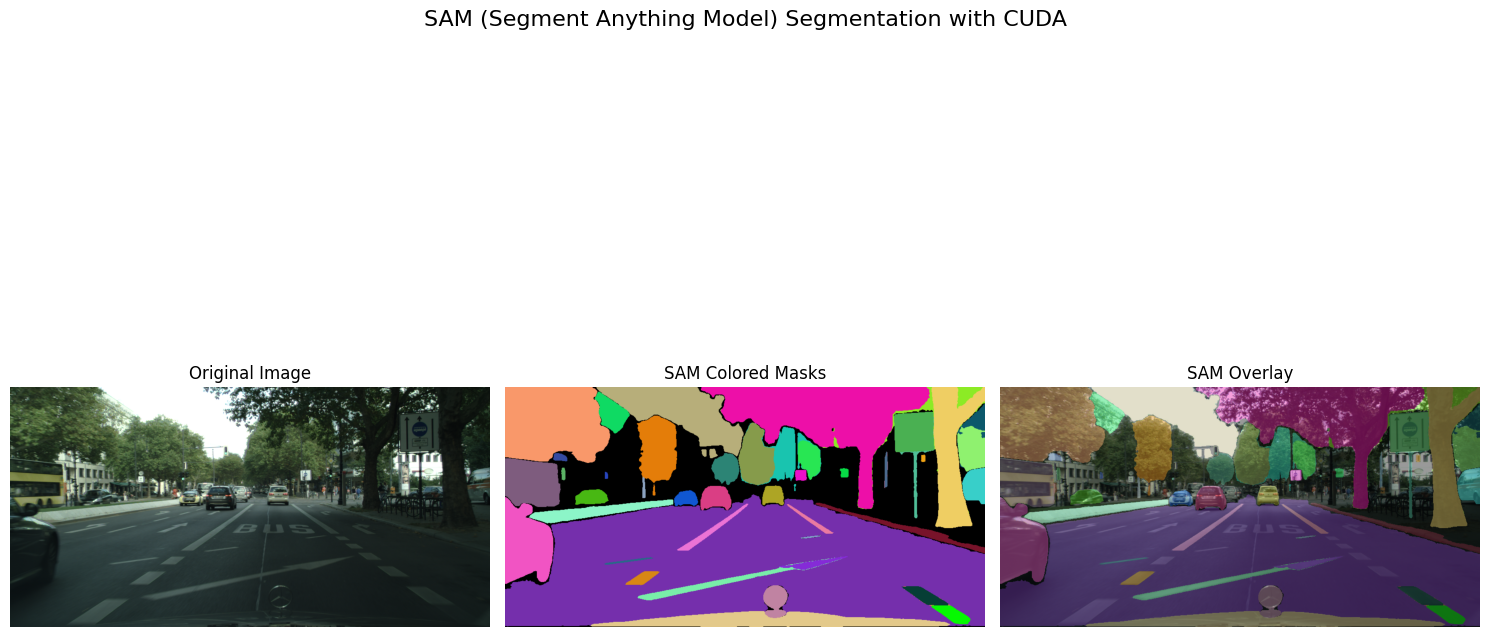


Found 25 individual masks:


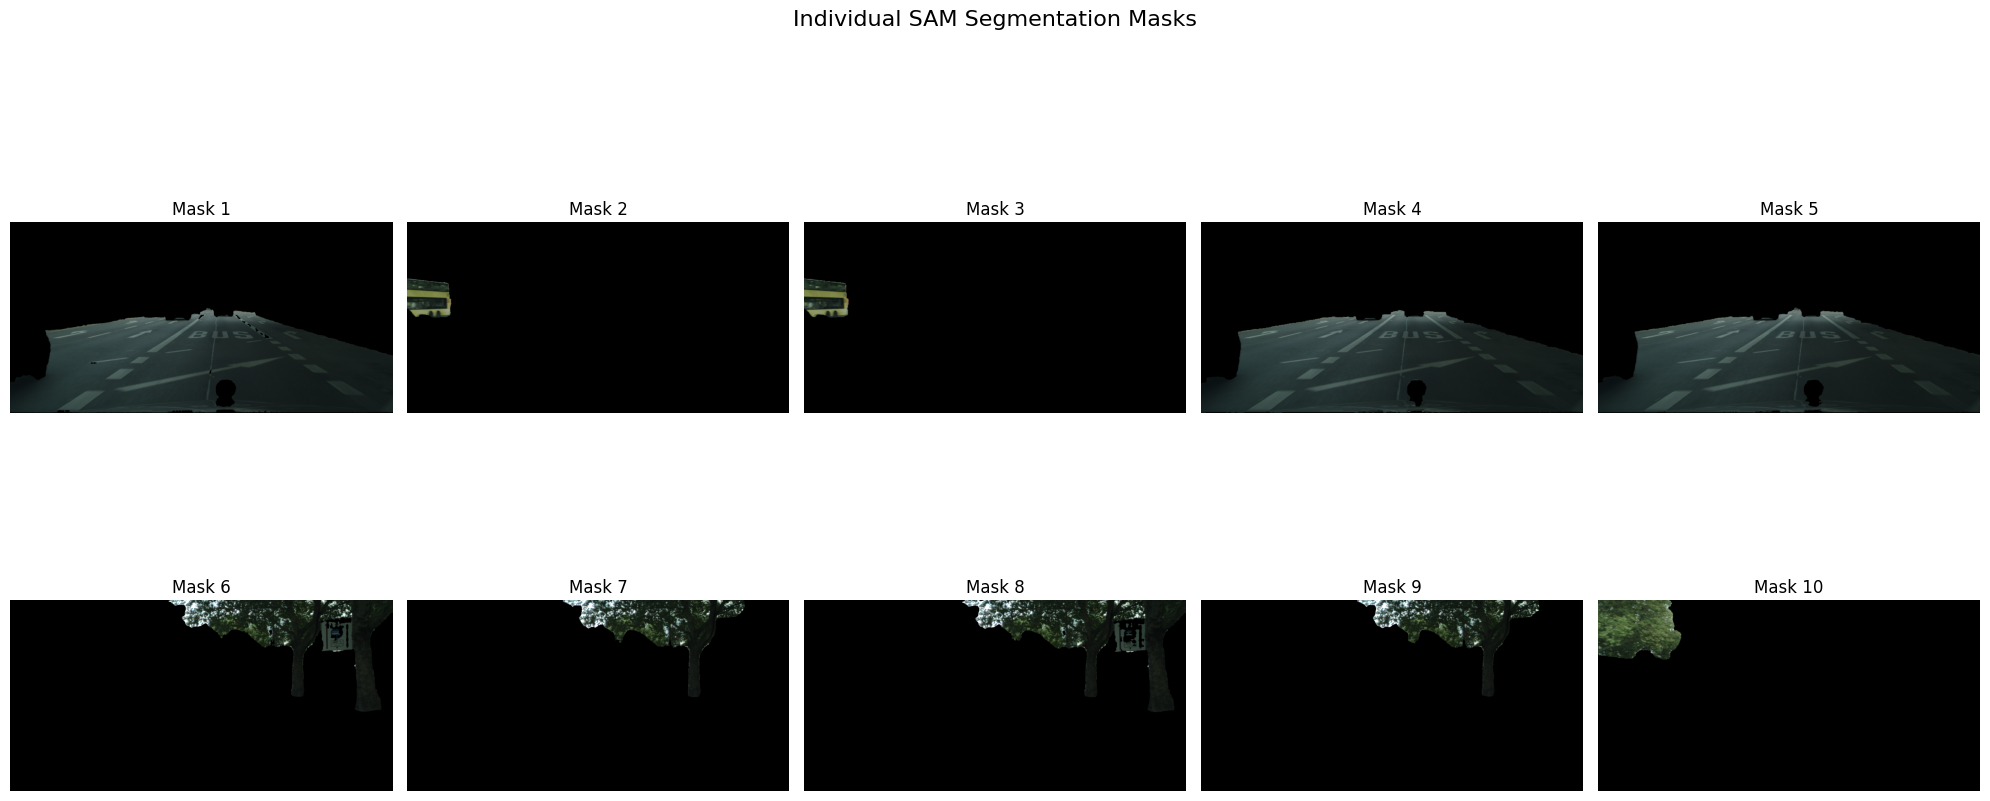

In [12]:
# SAM Integration Test
import subprocess, sys, shutil, os
dnn_exe_path = os.path.join('..', 'build', 'Debug', 'dnn_segmentation.exe')

if os.path.exists(dnn_exe_path):
    # Run the DNN segmentation executable with SAM
    proc = subprocess.run([dnn_exe_path, '../dataset/leftImg8bit_trainvaltest/test/berlin/berlin_000000_000019_leftImg8bit.png', '--use-sam', '--no-gui'], 
                         capture_output=True, text=True)
    print('returncode =', proc.returncode)
    print('stdout:\n', proc.stdout)
    if proc.stderr:
        print('stderr:\n', proc.stderr)
    
    if proc.returncode == 0:
        from PIL import Image
        import matplotlib.pyplot as plt
        
        # Display SAM segmentation results
        out_dir = os.path.join('out_images', 'sam')
        sam_imgs = [
            'sam_original.png',
            'sam_colored_masks.png',
            'sam_overlay.png'
        ]
        
        titles = [
            'Original Image',
            'SAM Colored Masks',
            'SAM Overlay'
        ]
        
        plt.figure(figsize=(15,10))
        found_images = 0
        for i, (name, title) in enumerate(zip(sam_imgs, titles), 1):
            path = os.path.join(out_dir, name)
            if os.path.exists(path):
                im = Image.open(path).convert('RGB')
                plt.subplot(1,3,i)
                plt.imshow(im)
                plt.title(title)
                plt.axis('off')
                found_images += 1
            else:
                print(f"Image not found: {path}")
        
        if found_images > 0:
            plt.suptitle('SAM (Segment Anything Model) Segmentation with CUDA', fontsize=16)
            plt.tight_layout()
            plt.show()
            
            # Show individual masks if available
            import glob
            mask_files = glob.glob(os.path.join(out_dir, 'sam_mask_*.png'))
            if mask_files:
                print(f"\nFound {len(mask_files)} individual masks:")
                plt.figure(figsize=(20,10))
                for i, mask_file in enumerate(mask_files[:10], 1):  # Show up to 10 masks
                    im = Image.open(mask_file).convert('RGB')
                    plt.subplot(2,5,i)
                    plt.imshow(im)
                    plt.title(f"Mask {i}")
                    plt.axis('off')
                plt.suptitle('Individual SAM Segmentation Masks', fontsize=16)
                plt.tight_layout()
                plt.show()
        else:
            print("No SAM segmentation results found")
    else:
        print(f"SAM segmentation failed with return code {proc.returncode}")
        print("This could be due to:")
        print("1. CUDA out of memory - try with --max-size 512")
        print("2. SAM model not found - check models directory")
        print("3. Python dependencies missing")
else:
    print('DNN segmentation executable not found at', dnn_exe_path)
    print('Please build the project first using: cmake --build build --config Debug')